In [2]:
import importlib

import numpy as np
import ParseING11 as parse
import check_configs as configcheck


importlib.reload(parse)
importlib.reload(configcheck)

<module 'check_configs' from 'c:\\Users\\bowie\\Documents\\GitHub\\CUDA-cowan\\check_configs.py'>

In [14]:
# aligning the scraped data with predicitions of amounts of F, G, zeta etc 
def check(filename):
    parseddata = parse.main(filename)

    alignment = []
    # values for our 
    for key, value in parseddata[1].items():
        configdict = configcheck.main(key.split()[1])
        print(key, len(value), sum(configdict.values())) #Number of output values scraped, number of output values predicted
        print(key, value, configdict)
        alignment.append(len(value) == sum(configdict.values())) # list of bools for checked configurations

    return alignment

for i in range(1,8):
    filename = f"ING11_{i}.txt"
    alignment = check(filename)
    print(filename, alignment, "\n")


Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p54d3 8 8
Sn12+ 4p54d3 ['66222390', '10130381', '6849531', '4760122', '488602', '10571913', '13412004', '8461844'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 2, 'Fk_ij': 1, 'Gk_ij': 2}
Sn12+ 4p64f1 7 2
Sn12+ 4p64f1 ['70822700', '490632', '38732', '6138173', '11094824', '7137444', '5102384'] {'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
ING11_1.txt [True, True, False] 

Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p64f1 7 2
Sn12+ 4p64f1 ['70822700', '490632', '38732', '6138173', '11094824', '7137444', '5102384'] {'Eav': 1, 'Fk_ii': 0, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
ING11_2.txt [True, False] 

Sn12+ 4p64d2 4 4
Sn12+ 4p64d2 ['5675090', '10124861', '6846241', '486792'] {'Eav': 1, 'Fk_ii': 2, 'zeta': 1, 'Fk_ij': 0, 'Gk_ij': 0}
Sn12+ 4p54d3 8 8
Sn12+ 4p54d3

Lets continue with cases ING11_3, 5, 6, 7 since they work properly. Now that we have 

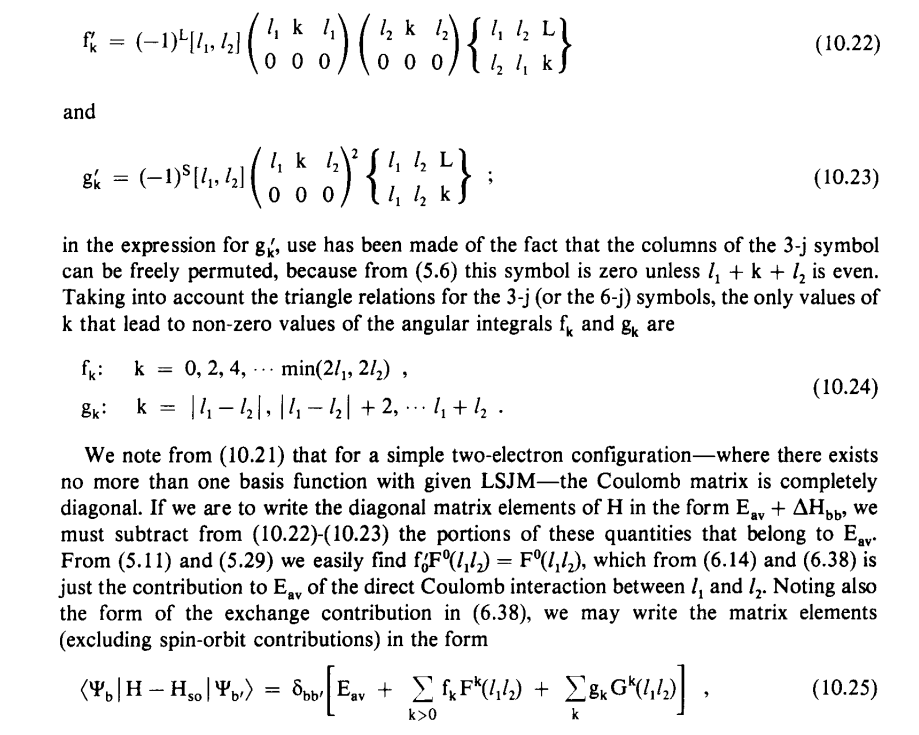

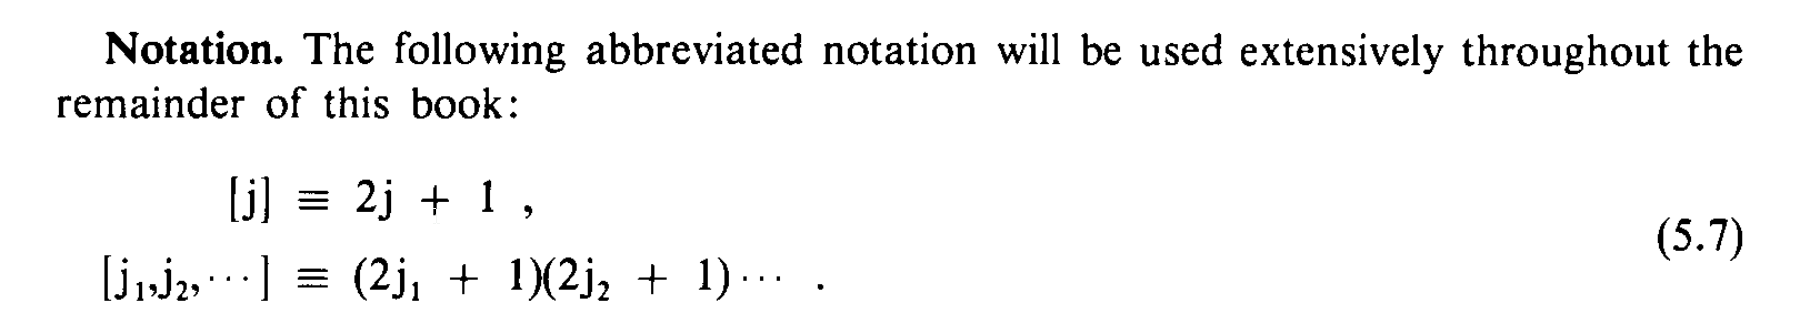

In [21]:
from sympy.physics.wigner import wigner_3j, wigner_6j
import re


# Example calculations
#print(wigner_3j(2, 2, 4, 0, 0, 0))  # Example Wigner 3j symbol
#print(wigner_6j(1, 2, 3, 4, 5, 6))  # Example Wigner 6j symbol


def fk(l1, l2, k):
    if k % 2 != 0:
        return 0
    elif k > min(2*l1,2*l2):
        return 0
    L = l1 + l2
    return (-1)**L*(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l1, 0, 0, 0)*wigner_3j(l2, k ,l2, 0, 0, 0)*wigner_6j(l2, l1 ,L, l2, l1, k)

def gk(l1, l2, k, S):
    if k < abs(l1 - l2):
        return 0
    if k > l1 + l2:
        return 0
    L = l1 + l2
    return (-1)**S**(2*l1 +1)*(2*l2 +1)*wigner_3j(l1, k ,l2, 0, 0, 0)**2 *wigner_6j(l1, l2 ,L, l1, l2, k)


def parse_parameters(values, count_dict):
    """Split the flat value list into chunks based on count_dict."""
    parsed = {}
    idx = 0
    for key, count in count_dict.items():
        parsed[key] = [int(values[idx + i]) for i in range(count)]
        idx += count
    return parsed

def parse_subshells(subshells):
    """Parses subshells like '4p5' or '4d10' into (l, N) tuples."""
    l_map = {'s': 0, 'p': 1, 'd': 2, 'f': 3}
    parsed = []
    for shell in subshells:
        match = re.match(r'(\d)([spdf])(\d+)', shell)
        if not match:
            raise ValueError(f"Invalid subshell format: {shell}")
        n_str, l_str, N_str = match.groups()
        l = l_map[l_str]
        N = int(N_str)
        parsed.append((l, N))
    return parsed

def valid_k_values_fk(l1, l2):
    return list(range(0, 2 * min(2 * l1, 2 * l2) + 1, 2))

def valid_k_values_gk(l1, l2):
    start = abs(l1 - l2)
    return list(range(start, l1 + l2 + 1, 2))

In [24]:
import numpy as np
from itertools import product


# Example usage format
example_data = [
    ("Sn12+ 4p54d3", ['66222390', '10130381', '6849531', '4760122', '488602', '10571913', '13412004', '8461844'],
     {'Eav': 1, 'Fk_ii': 2, 'zeta': 2, 'Fk_ij': 1, 'Gk_ij': 2})
]

def generate_matrices(configurations):
    matrices = {}

    for config_string, values, count_dict in configurations:
        # Parse config string
        element_config = config_string.split()
        label = element_config[0]
        
        subshell_string = element_config[1]
        subshells = re.findall(r'\\d[spdf]\\d+', subshell_string)
        shell_info = parse_subshells(subshells)


        # Extract parameter values from flat list
        parsed_values = parse_parameters(values, count_dict)

        # Split values
        Eav_val = parsed_values['Eav'][0]
        fk_ii_vals = parsed_values.get('Fk_ii', [])
        fk_ij_vals = parsed_values.get('Fk_ij', [])
        gk_ij_vals = parsed_values.get('Gk_ij', [])

        matrix_index = 0

        print(shell_info)
        print(parsed_values)
        print(Eav_val, fk_ii_vals, fk_ij_vals, gk_ij_vals)


        for (l1, N1), (l2, N2) in product(shell_info, repeat=2):
            if (l1, N1) > (l2, N2):
                continue

            L_values = range(abs(l1 - l2), l1 + l2 + 1 + 1, 1)
            S_values = [0, 1]  # singlet/triplet

            fk_vals = fk_ij_vals if l1 != l2 else fk_ii_vals
            gk_vals = gk_ij_vals if l1 != l2 else []

            fk_ks = valid_k_values_fk(l1, l2)
            gk_ks = valid_k_values_gk(l1, l2)

            for L, S in product(L_values, S_values):
                fk_sum = sum(fk_vals[i] for i in range(min(len(fk_vals), len(fk_ks))))
                gk_sum = sum(gk_vals[i] for i in range(min(len(gk_vals), len(gk_ks))))

                diag_element = Eav_val + fk_sum + gk_sum

                key = (label, tuple(subshells), f"matrix_{matrix_index}")

                if key not in matrices:
                    matrices[key] = []
                matrices[key].append(diag_element)

                matrix_index += 1

    return matrices

# Call it like this:
matrices = generate_matrices(example_data)
#print(matrices)


[]
{'Eav': [66222390], 'Fk_ii': [10130381, 6849531], 'zeta': [4760122, 488602], 'Fk_ij': [10571913], 'Gk_ij': [13412004, 8461844]}
66222390 [10130381, 6849531] [10571913] [13412004, 8461844]
